# CSE 572: Lab 17

In this lab, you will practice measuring cluster validity with unsupervised metrics and applying clustering to a real world problem.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Scenario 🏀

Your friends and family have created a contest to see who can best predict the outcome of the [NCAA Men's Basketball Tournament](https://www.ncaa.com/news/basketball-men/bracketiq/2023-03-15/what-march-madness-ncaa-tournament-explained). 

Being a data scientist, you want to use what you've learned in Data Mining to help you decide who you think will win in each round of the tournament.

Luckily, you have access to a [dataset created by FiveThirtyEight](https://projects.fivethirtyeight.com/2023-march-madness-predictions/) that gives their predicted probability of each team winning each of the 7 rounds of the tournament, along with some other metadata about the teams.

Your goal is to use clustering algorithms to determine how to group the overall win-ability of the teams. You will create multiple clusterings and use cluster validity measures to evaluate which clustering is best. You will use your final choice of clustering to determine which group of teams is most likely to lose in the first round and make it to the Championship.

### Load the dataset

In [72]:
import pandas as pd
df = pd.read_csv('https://projects.fivethirtyeight.com/march-madness-api/2023/fivethirtyeight_ncaa_forecasts.csv')

In [73]:
df.sample(10)

,gender,forecast_date,playin_flag,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,results_to,team_alive,team_id,team_name,team_rating,team_region,team_seed,team_slot
508,womens,2023-03-20,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7,0,2450,Norfolk State,66.68,Greenville 1,16,2
724,womens,2023-03-17,0,1.000000,0.050831,0.009634,0.000034,0.000002,9.922000e-08,7.414000e-09,1,1,16,Sacramento State,72.81,Greenville 1,13,14
203,mens,2023-03-17,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7,0,344,Mississippi State,81.85,Midwest,11a,114
128,mens,2023-03-18,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7,0,66,Iowa State,84.52,Midwest,6,112
8,mens,2023-03-19,0,1.000000,1.000000,1.000000,0.244941,0.129541,7.415512e-02,2.716084e-02,3,1,21,San Diego State,88.55,South,5,8
322,mens,2023-03-15,0,1.000000,0.153608,0.067351,0.014643,0.003315,7.096082e-04,2.029936e-04,1,1,314,Iona,79.63,West,13,78
675,womens,2023-03-18,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7,0,2241,Gardner-Webb,69.90,Greenville 2,15,126
471,mens,2023-03-12,1,0.541226,0.008254,0.000844,0.000117,0.000012,1.970301e-06,2.423360e-07,0,1,357,Texas A&M-Corpus Christi,69.92,South,16a,2
918,womens,2023-03-12,0,1.000000,0.414686,0.097187,0.011832,0.002836,5.531121e-04,3.528885e-05,1,1,526,Florida Gulf Coast,82.94,Greenville 2,12,106
559,womens,2023-03-19,0,1.000000,1.000000,0.808357,0.168211,0.052535,1.408182e-02,1.554080e-03,2,1,222,Villanova,88.73,Greenville 2,4,108


In this lab, we are only going to analyze the Men's Tournament (but you are encouraged to do another analysis on your own for the women's tournament!). Filter `df` to include only the men's teams.

In [74]:
# YOUR CODE HERE
df = df[df['gender'] == 'mens']

In [75]:
df.head()

,gender,forecast_date,playin_flag,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,results_to,team_alive,team_id,team_name,team_rating,team_region,team_seed,team_slot
0,mens,2023-03-19,0,1.0,1.0,1.0,0.788753,0.508717,0.379961,0.268753,3,1,248,Houston,93.31,Midwest,1,96
1,mens,2023-03-19,0,1.0,1.0,1.0,0.755059,0.551259,0.399579,0.203867,3,1,333,Alabama,93.12,South,1,0
2,mens,2023-03-19,0,1.0,1.0,1.0,0.700332,0.318489,0.199100,0.118130,3,1,251,Texas,90.75,Midwest,2,124
3,mens,2023-03-19,0,1.0,1.0,1.0,0.828461,0.295870,0.170574,0.063048,3,1,156,Creighton,89.01,South,6,16
4,mens,2023-03-19,0,1.0,1.0,1.0,0.661836,0.399818,0.157617,0.057170,3,1,2633,Tennessee,88.59,East,4,44


We are also going to filter `df` to include stats from the March 12 forecast date (before the tournament began) and teams that are still are alive (still in the tournament). Apply those filters below (hint: this should result in a dataframe of 68 teams).

In [76]:
df = df[(df['team_alive'] == 1) & (df['forecast_date'] == '2023-03-12')]

In [77]:
df

,gender,forecast_date,playin_flag,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,results_to,team_alive,team_id,team_name,team_rating,team_region,team_seed,team_slot
408,mens,2023-03-12,0,1.000000,0.971048,0.741489,0.588248,0.406558,3.086215e-01,2.208502e-01,1,1,248,Houston,93.22,Midwest,1,96
409,mens,2023-03-12,0,1.000000,0.986018,0.819507,0.654196,0.452906,3.049179e-01,1.617612e-01,1,1,333,Alabama,92.57,South,1,0
410,mens,2023-03-12,0,1.000000,0.921392,0.646432,0.452847,0.222234,1.400075e-01,8.269913e-02,1,1,251,Texas,90.08,Midwest,2,124
411,mens,2023-03-12,0,1.000000,0.984874,0.694787,0.407203,0.253284,1.198275e-01,5.296822e-02,1,1,2509,Purdue,89.48,East,1,32
412,mens,2023-03-12,0,1.000000,0.978209,0.656921,0.389981,0.202775,9.126496e-02,4.955031e-02,1,1,2305,Kansas,89.62,West,1,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,mens,2023-03-12,1,0.541226,0.008254,0.000844,0.000117,0.000012,1.970301e-06,2.423360e-07,0,1,357,Texas A&M-Corpus Christi,69.92,South,16a,2
472,mens,2023-03-12,1,0.458774,0.005728,0.000488,0.000062,0.000006,6.233230e-07,4.952400e-08,0,1,2546,Southeast Missouri State,67.71,South,16b,3
473,mens,2023-03-12,0,1.000000,0.021791,0.001382,0.000097,0.000006,3.901620e-07,3.670900e-08,1,1,47,Howard,69.31,West,16,66
474,mens,2023-03-12,1,0.567977,0.009251,0.000533,0.000028,0.000002,1.908500e-07,1.915800e-08,0,1,2640,Texas Southern,66.56,East,16a,34


We will store the team names and overall team ratings in separate dataframes to make it easy to refer to these later in our analysis.

In [78]:
names = df['team_name']

In [79]:
ratings = df['team_rating']

We don't necessarily want to use all of the columns available for our clustering. For this analysis, we will choose to use only the columns that contain win probabilities for each round: `'rd1_win', 'rd2_win', 'rd3_win', 'rd4_win', 'rd5_win', 'rd6_win', 'rd7_win'`.

In [80]:
df = df[['rd1_win', 'rd2_win', 'rd3_win', 'rd4_win', 'rd5_win', 'rd6_win', 'rd7_win']]

Before we start applying and evaluating our clustering algorithms, we might first want to try to visualize the data to see what sort of structure exists. One way to visualize our data is using a scatter plot of a pair of features, e.g., `rd1_win` and `rd7_win`. 

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='rd1_win', ylabel='rd7_win'>

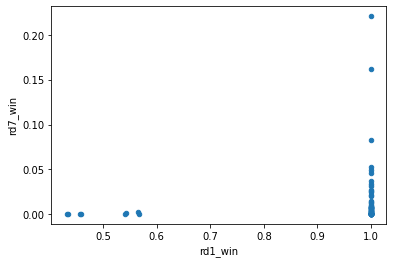

In [81]:
df.plot.scatter('rd1_win', 'rd7_win')

Another way to visualize our 7-dimensional dataset is by reducing the dimensionality to 2 using PCA, then plotting the scatter plot of the first two PCs. 

Do this in the cell below.

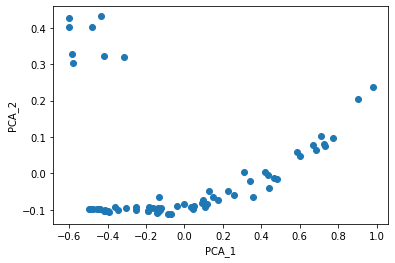

In [82]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)

plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

## Cluster the data

We will evaluate agglomerative clustering and K-means clustering for our dataset. First, we'll use the scipy library used in Lab 16 to cluster the data using the complete link (MAX) agglomerative clustering algorithm and visualize the resulting dendrogram. This dendrogram may also be useful to visualize the dataset if the clusters respond to meaningful taxonomies.

If you know anything about NCAA basketball teams already, maybe you will notice some interesting patterns in the tree!

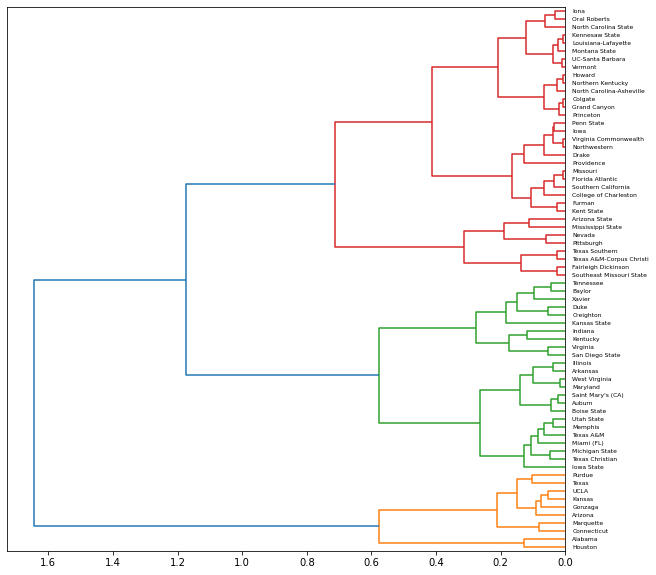

In [83]:
from scipy.cluster import hierarchy

fig, ax = plt.subplots(ncols=1, figsize=(10,10))
Z = hierarchy.linkage(df, 'complete')
dn = hierarchy.dendrogram(Z, labels=names.tolist(), orientation='left', ax=ax)

Since we will use Scikit-learn for K-means clustering, we'll recreate the agglomerative clustering using Scikit-learn too below. Recall that we can create a partitional clustering from a hierarchical clustering by cutting the dendrogram at a particular level. If we cut the dendrogram at about 0.5, our clustering would have 6 clusters. We will use this number of clusters for our Scikit-learn implementation below.

In [84]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(n_clusters=6, linkage='complete').fit(df)

# Add resulting cluster labels to dataframe
df['Agglom clusters'] = agglom.labels_

<ipython-input-84-dd05c1fe305e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Agglom clusters'] = agglom.labels_


In [85]:
df

,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,Agglom clusters
408,1.000000,0.971048,0.741489,0.588248,0.406558,3.086215e-01,2.208502e-01,4
409,1.000000,0.986018,0.819507,0.654196,0.452906,3.049179e-01,1.617612e-01,4
410,1.000000,0.921392,0.646432,0.452847,0.222234,1.400075e-01,8.269913e-02,5
411,1.000000,0.984874,0.694787,0.407203,0.253284,1.198275e-01,5.296822e-02,5
412,1.000000,0.978209,0.656921,0.389981,0.202775,9.126496e-02,4.955031e-02,5
...,...,...,...,...,...,...,...,...
471,0.541226,0.008254,0.000844,0.000117,0.000012,1.970301e-06,2.423360e-07,1
472,0.458774,0.005728,0.000488,0.000062,0.000006,6.233230e-07,4.952400e-08,1
473,1.000000,0.021791,0.001382,0.000097,0.000006,3.901620e-07,3.670900e-08,0
474,0.567977,0.009251,0.000533,0.000028,0.000002,1.908500e-07,1.915800e-08,1


We will also evaluate clusterings produced by K-means. First, we need to decide how many clusters to use. In the cell below, plot the SSE as a function of number of clusters for up to 15 clusters. Set the random seed to 0 for K-means.

Remember: Since you added the agglomerative clustering label as an extra column in `df`, you should ignore that column in your K-means clustering.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

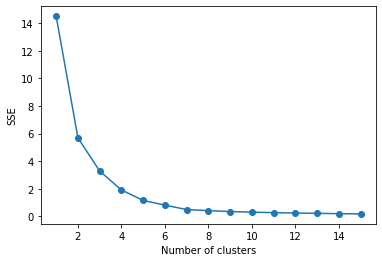

In [86]:
# YOUR CODE HERE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

dfKmeans = df.drop('Agglom clusters', axis=1)
sse = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dfKmeans)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 16), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


Looking at the plot above, it looks like the decrease in SSE starts to plateau after 5 or 6 clusters. 

In the cell below, cluster the data using K-means with 5 clusters and with 6 clusters. Set the random state to 0.

Then add the resulting cluster labels for each clustering as two new columns in our dataframe `df` called `KM5 clusters` and `KM6 clusters`.  

In [87]:
# YOUR CODE HERE

# K-means with 5 clusters
kmeans5 = KMeans(n_clusters=5, random_state=0)
kmeans5.fit(dfKmeans)
df['KM5 clusters'] = kmeans5.labels_

# K-means with 6 clusters
kmeans6 = KMeans(n_clusters=6, random_state=0)
kmeans6.fit(dfKmeans)
df['KM6 clusters'] = kmeans6.labels_


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-87-9dacf8756f4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KM5 clusters'] = kmeans5.labels_
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-87-9dacf8756f4a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [88]:
df

,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,Agglom clusters,KM5 clusters,KM6 clusters
408,1.000000,0.971048,0.741489,0.588248,0.406558,3.086215e-01,2.208502e-01,4,3,3
409,1.000000,0.986018,0.819507,0.654196,0.452906,3.049179e-01,1.617612e-01,4,3,3
410,1.000000,0.921392,0.646432,0.452847,0.222234,1.400075e-01,8.269913e-02,5,3,3
411,1.000000,0.984874,0.694787,0.407203,0.253284,1.198275e-01,5.296822e-02,5,3,3
412,1.000000,0.978209,0.656921,0.389981,0.202775,9.126496e-02,4.955031e-02,5,3,3
...,...,...,...,...,...,...,...,...,...,...
471,0.541226,0.008254,0.000844,0.000117,0.000012,1.970301e-06,2.423360e-07,1,2,2
472,0.458774,0.005728,0.000488,0.000062,0.000006,6.233230e-07,4.952400e-08,1,2,2
473,1.000000,0.021791,0.001382,0.000097,0.000006,3.901620e-07,3.670900e-08,0,4,1
474,0.567977,0.009251,0.000533,0.000028,0.000002,1.908500e-07,1.915800e-08,1,2,2


### Cluster validity

Now we have 3 different clusterings that we need to evaluate. First, let's visualize the three different clusterings in our PCA visualization of the data.

Text(0.5, 1.0, 'Agglomerative (k=6)')

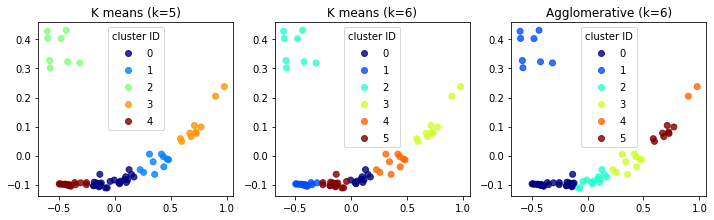

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
fig.tight_layout()

sc1 = ax[0].scatter(pca_data[:,0], pca_data[:,1], alpha=0.8, c=df['KM5 clusters'], cmap='jet')
ax[0].legend(*sc1.legend_elements(), title='cluster ID')
ax[0].set_title('K means (k=5)')

sc2 = ax[1].scatter(pca_data[:,0], pca_data[:,1], alpha=0.8, c=df['KM6 clusters'], cmap='jet')
ax[1].legend(*sc2.legend_elements(), title='cluster ID')
ax[1].set_title('K means (k=6)')

sc3 = ax[2].scatter(pca_data[:,0], pca_data[:,1], alpha=0.8, c=df['Agglom clusters'], cmap='jet')
ax[2].legend(*sc3.legend_elements(), title='cluster ID')
ax[2].set_title('Agglomerative (k=6)')

Visually, we might have a hard time deciding which clustering is best. Remember that we aren't seeing the original data that was clustered here---this is the data in PCA space, so it may not tell us the full story.  

To quantify the goodness of each clustering, we will use cluster validity metrics. We don't have ground truth classes (or classification labels), so we need to use unsupervised metrics such as Silhouette score and sum of squared errors (SSE or inertia).

In the cell below, compute the silhouette score of each of the 3 clusterings. Remember to exclude the cluster labels from the data (first argument of `silhouette_score()`).

In [90]:
# YOUR CODE HERE
from sklearn.metrics import silhouette_score

agg_score = silhouette_score(dfKmeans, df['Agglom clusters'])

kmeans5_score = silhouette_score(dfKmeans, df['KM5 clusters'])

kmeans6_score = silhouette_score(dfKmeans, df['KM6 clusters'])

print('Agglomerative clustering silhouette score:', agg_score)
print('K-means clustering with 5 clusters silhouette score:', kmeans5_score)
print('K-means clustering with 6 clusters silhouette score:', kmeans6_score)


Agglomerative clustering silhouette score: 0.5343795328238091
K-means clustering with 5 clusters silhouette score: 0.5476101035667716
K-means clustering with 6 clusters silhouette score: 0.5693157227229668


**Question 1: Which clustering has the best Silhouette score?**

**Answer:**

YOUR ANSWER HERE

K-means clustering with 6 clusters silhouette score: 0.5693157227229668 has the best score amongst the three

Using the clustering with the best silhouette score, print the following for each cluster:
- The names of the teams that were assigned to the cluster (i.e., you should print a list of names for each of the clusters)
- The average rating of the teams that were assigned to the cluster (i.e., you should print the mean of the `team_rating` over the teams in each cluster)

In [91]:
# YOUR CODE HERE

df = pd.concat([df, names, ratings], axis=1)
cluster_means = df.groupby('KM6 clusters')['team_rating'].mean()

for cluster in cluster_means.index:
    team_names = df.loc[df['KM6 clusters'] == cluster, 'team_name'].tolist()
    avg_rating = cluster_means[cluster]
    print(f'Cluster {cluster}:')
    print(f'Team Names: {team_names}')
    print(f'Average Rating: {avg_rating:.2f}')
    print()



Cluster 0:
Team Names: ['Texas A&M', 'Texas Christian', 'Iowa State', 'Auburn', 'Memphis', "Saint Mary's (CA)", 'Arkansas', 'Michigan State', 'Miami (FL)', 'Utah State', 'Boise State']
Average Rating: 84.49

Cluster 1:
Team Names: ['North Carolina State', 'Oral Roberts', 'Iona', 'Louisiana-Lafayette', 'Vermont', 'Grand Canyon', 'Colgate', 'Montana State', 'UC-Santa Barbara', 'Princeton', 'Kennesaw State', 'Northern Kentucky', 'North Carolina-Asheville', 'Howard']
Average Rating: 75.69

Cluster 2:
Team Names: ['Mississippi State', 'Arizona State', 'Pittsburgh', 'Nevada', 'Texas A&M-Corpus Christi', 'Southeast Missouri State', 'Texas Southern', 'Fairleigh Dickinson']
Average Rating: 73.75

Cluster 3:
Team Names: ['Houston', 'Alabama', 'Texas', 'Purdue', 'Kansas', 'Gonzaga', 'Arizona', 'UCLA', 'Connecticut', 'Marquette']
Average Rating: 89.90

Cluster 4:
Team Names: ['Baylor', 'Creighton', 'Duke', 'Tennessee', 'Kentucky', 'Indiana', 'San Diego State', 'Xavier', 'Kansas State', 'Virginia']

**Question 2: Suppose you used your clustering results to help choose teams in your own tournament bracket predictions. Since Cluster 2 had the lowest average rating, you decide that those are the teams you will predict to lose in the first round.**

**Visit the [FiveThirtyEight website](https://projects.fivethirtyeight.com/2023-march-madness-predictions/) to see the current standings. How many of your teams in Cluster 2 made it to the first round and won (i.e., you were wrong about them losing in round 1)?** 


**Answer:**

YOUR ANSWER HERE

| Team | Made it to Round 1 | Win / Loose |
|----------|----------|----------|
| Mississippi State       | No  | N/A |
| Arizona State           | Yes | No  |
| Pittsburgh              | Yes | Yes |
| Nevada                  | No  | N/A |
| Texas A&M-Corpus Christi| Yes | No  |
| Southeast Missouri State| No  | N/A |
| Texas Southern          | No  | No  |
| Fairleigh Dickinson     | Yes | Yes |



Seeing the above table, we can say, **Pittsburgh** and **Fairleigh Dickinson** are the only **Two** teams which made it to first round and won which we were wrong about.


**Question 3: Only two teams will make it to the Championship game of the tournament. Using your clustering results, which two teams would you predict will make it to the Championship game?**

**Answer:**

YOUR ANSWER HERE \

I would predict Houston and Alabama will make it to the Championship game as they come from the cluster 3 which has highest rating and these two teams have their individual ratings as 93.22 and 92.57 respectively.